In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.models import vgg16, VGG16_Weights
import os

In [2]:
classes = (
    'Rottweiler', 
    'Dachshund', 
    'Yorkshire_Terrier', 
    'Beagle', 
    'Golden_Retriever',
    'Poodle', 
    'Labrador_Retriever', 
    'German_Shepherd',
    'Boxer', 
    'Bulldog'
)

dict = {
    'Rottweiler' : 0, 
    'Dachshund' : 1, 
    'Yorkshire_Terrier': 2, 
    'Beagle' : 3, 
    'Golden_Retriever': 4,
    'Poodle' : 5, 
    'Labrador_Retriever': 6, 
    'German_Shepherd': 7,
    'Boxer': 8, 
    'Bulldog' : 9
}

In [3]:
data_path = ("./data/dataset")
folders = os.listdir(data_path)
dataset = []
for f in folders:
    img = os.listdir(data_path + "/" + f)
    for i in img:
        dataset.append((i, f))

In [4]:
dataset

[('Rottweiler_15.jpg', 'Rottweiler'),
 ('Rottweiler_29.jpg', 'Rottweiler'),
 ('Rottweiler_28.jpg', 'Rottweiler'),
 ('Rottweiler_14.jpg', 'Rottweiler'),
 ('Rottweiler_16.jpg', 'Rottweiler'),
 ('Rottweiler_17.jpg', 'Rottweiler'),
 ('Rottweiler_13.jpg', 'Rottweiler'),
 ('Rottweiler_12.jpg', 'Rottweiler'),
 ('Rottweiler_38.jpg', 'Rottweiler'),
 ('Rottweiler_10.jpg', 'Rottweiler'),
 ('Rottweiler_11.jpg', 'Rottweiler'),
 ('Rottweiler_39.jpg', 'Rottweiler'),
 ('Rottweiler_76.jpg', 'Rottweiler'),
 ('Rottweiler_89.jpg', 'Rottweiler'),
 ('Rottweiler_6.jpg', 'Rottweiler'),
 ('Rottweiler_88.jpg', 'Rottweiler'),
 ('Rottweiler_63.jpg', 'Rottweiler'),
 ('Rottweiler_77.jpg', 'Rottweiler'),
 ('Rottweiler_61.jpg', 'Rottweiler'),
 ('Rottweiler_75.jpg', 'Rottweiler'),
 ('Rottweiler_49.jpg', 'Rottweiler'),
 ('Rottweiler_4.jpg', 'Rottweiler'),
 ('Rottweiler_5.jpg', 'Rottweiler'),
 ('Rottweiler_74.jpg', 'Rottweiler'),
 ('Rottweiler_58.jpg', 'Rottweiler'),
 ('Rottweiler_64.jpg', 'Rottweiler'),
 ('Rottweiler_7

In [5]:
class DogBreedDataSet(Dataset):
    def __init__(self,root, transform = None):
        self.x = []
        self.y = []
        self.transform = transform
        self.root = root
        folders = os.listdir(root)
        for f in folders:
            img = os.listdir(root + "/" + f)
            for i in img:
                self.x.append(i)
                self.y.append(dict[f])
                
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self,index):
        path = f"{self.root}/{classes[self.y[index]]}/{self.x[index]}"
        img = read_image(path)
        img = img.to(torch.float32) / 255.0
        if self.transform:
            img = self.transform(img)
        return (img, self.y[index])

    def show_img(self, index):
        path = f"{self.root}/{classes[self.y[index]]}/{self.x[index]}"
        img = read_image(path)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(classes[self.y[index]])
        plt.show()
        

In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to the target size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset = DogBreedDataSet("./data/dataset", transform)

In [7]:
dataset[9][0].shape

torch.Size([3, 64, 64])

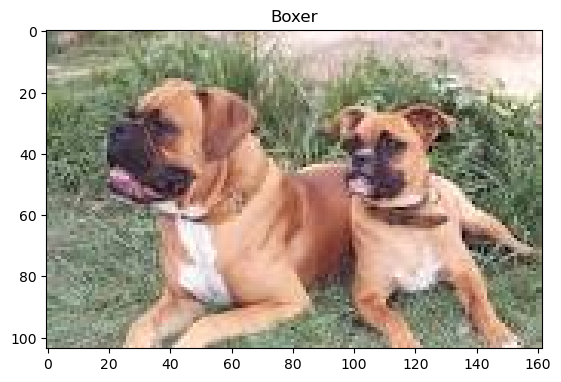

In [8]:
dataset.show_img(800)

In [9]:
len(dataset.x)

967

In [10]:
trainset = DataLoader(dataset, batch_size = 16, shuffle = True)
valset = DataLoader(dataset, batch_size = 16, shuffle = False)

Build model

In [32]:
def train_one_epoch(model, trainset, optim, loss_fn):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for batch, (x,y) in enumerate(trainset):
        optim.zero_grad()
        
        outputs = model(x)
        loss = loss_fn(outputs, y) 
        running_loss += loss
        loss.backward()
        optim.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * x.size(0)
        correct += torch.sum(preds == y)
        if batch % 50 == 0: 
            print(f"Batches: {batch}/{int(len(trainset.dataset) * 16)}")
            print(f"Current loss: {running_loss / (batch * 16)}")
            
    epoch_loss = running_loss / len(trainset.dataset)
    epoch_acc = correct / len(trainset.dataset)

    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

In [13]:
def test_model(model, testset, loss_fn):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in testset:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return epoch_loss, epoch_acc

In [75]:
num_classes = 10 

VGG16 = vgg16(pretrained=True) 

VGG16.classifier[6] = nn.Linear(4096, num_classes)

for param in VGG16.classifier[6].parameters():
    param.requires_grad = True


In [79]:
batch_size = 16
epochs = 10
lr = 0.001

optim = torch.optim.SGD(VGG16.classifier[6].parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    
    VGG16.train()
    running_loss = 0
    total = 0
    correct = 0
    for batch, (x,y) in enumerate(trainset):
        optim.zero_grad()
        
        outputs = VGG16(x)
        loss = loss_fn(outputs, y) 
        running_loss += loss
        loss.backward()
        optim.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * x.size(0)
        correct += torch.sum(preds == y)
        if batch % 10 == 0 and batch != 0: 
            print(f"Batches: {batch}/{int(len(trainset.dataset) * 16)}")
            print(f"Current loss: {running_loss / (batch * 16)}")
            
    epoch_loss = running_loss / len(trainset.dataset)
    epoch_acc = correct / len(trainset.dataset)

    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

Epoch 1/10
----------
Batches: 10/15472
Current loss: 3.020542860031128
Batches: 20/15472
Current loss: 2.426626682281494
Batches: 30/15472
Current loss: 2.151251792907715
Batches: 40/15472
Current loss: 1.944588303565979
Batches: 50/15472
Current loss: 1.780595064163208
Batches: 60/15472
Current loss: 1.6365678310394287
Training Loss: 1.6247 Acc: 0.4964
Epoch 2/10
----------
Batches: 10/15472
Current loss: 0.9905344843864441
Batches: 20/15472
Current loss: 0.899290919303894
Batches: 30/15472
Current loss: 0.8172293901443481
Batches: 40/15472
Current loss: 0.7762521505355835
Batches: 50/15472
Current loss: 0.7528123259544373
Batches: 60/15472
Current loss: 0.7217695713043213
Training Loss: 0.7165 Acc: 0.7901
Epoch 3/10
----------
Batches: 10/15472
Current loss: 0.6306110620498657
Batches: 20/15472
Current loss: 0.5791398286819458
Batches: 30/15472
Current loss: 0.572206437587738
Batches: 40/15472
Current loss: 0.5333799123764038
Batches: 50/15472
Current loss: 0.5358753204345703
Batche

In [81]:
count = 0
for k in range(len(dataset)):
    item = dataset[k]
    x = item[0].reshape(1, 3, 64,64)
    y = item[1]
    VGG16.eval()
    with torch.no_grad():
        output = VGG16(x)
        _, preds = torch.max(output, 1)
        if y == preds:
            #dataset.show_img(k)
            #print(classes[y])
            #print(classes[preds])
            count += 1
print(count)


965


In [83]:
len(dataset)

967

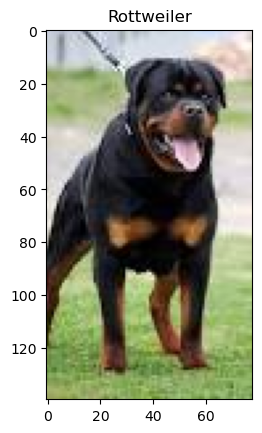

Rottweiler
Rottweiler


In [89]:
k = 60
item = dataset[k]
x = item[0].reshape(1, 3, 64,64)
y = item[1]
VGG16.eval()
with torch.no_grad():
    output = VGG16(x)
    _, preds = torch.max(output, 1)
    dataset.show_img(k)
    print(classes[y])
    print(classes[preds])

In [111]:
img = read_image('./data/dog.jpeg')
img = img.to(torch.float32) / 255.0
img = transform(img)
img = img.reshape(1, 3, 64,64)

In [113]:
output = VGG16(img)